# MODEL OLUŞTURMA

__HAM VERİ GÖRSELLEŞTİRME__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/preprocessed_review.csv")

__Labellar yapıldı ve sentiment analizi için yeni veriler elde edildi__

In [3]:
def label_review(rate):
    if rate >= 4: return 'positive'
    elif rate == 3: return 'neutral'
    else: return 'negative'

df['sentiment'] = df['Puan'].apply(label_review)

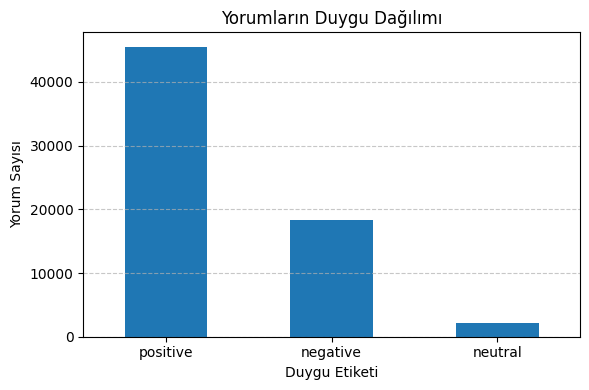

In [4]:
plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar')

plt.title('Yorumların Duygu Dağılımı')
plt.xlabel('Duygu Etiketi')
plt.ylabel('Yorum Sayısı')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

__Görüldüğü üzerine pozitif ve negatif yorum sayısı neutral sayısına göre oldukça az olduğu belli bu bize ileride neutral veri eğitiminde oldukça düşük doğruluk verecektir__

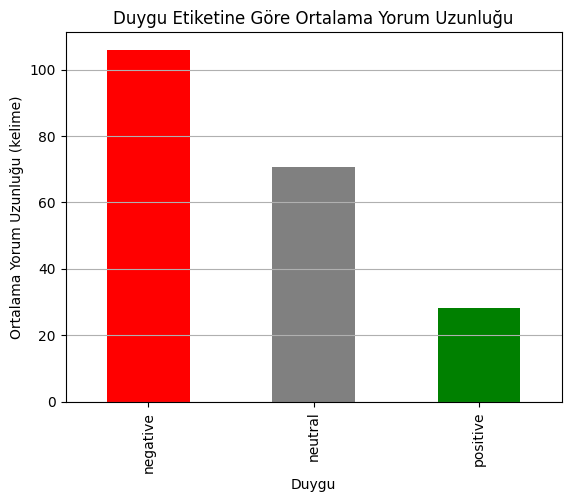

In [5]:
df["review_length"] = df["lemmas"].apply(len)
df.groupby("sentiment")["review_length"].mean().reindex(["negative", "neutral", "positive"]).plot(
    kind="bar", color=["red", "gray", "green"]
)
plt.title("Duygu Etiketine Göre Ortalama Yorum Uzunluğu")
plt.xlabel("Duygu")
plt.ylabel("Ortalama Yorum Uzunluğu (kelime)")
plt.grid(axis='y')
plt.show()

# SENTIMENT ANALYSIS

__transformation tabanlı model analizi burada hugging face araştırmaları sonucunda tabularisai/multilingual-sentiment-analysis seçildi bunun sebebi diğer turkçe modellerin veri setimde oldukça olumsuz sonuçlar vermesi verimizin çok çeşitli olmasından dolayı doğruluk olarak iyi sonuçlar elde edilemedi bunun sonucunda bu global ve 15 dili destekli model tercih edildi ve görece iyi sonuçlar elde edildi.__

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "tabularisai/multilingual-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [7]:
import ast

texts = df["lemmas"].dropna().apply(lambda x: " ".join(ast.literal_eval(x))).tolist()
results = sentiment_pipe(texts, batch_size=128)

In [8]:
df["pred_label"] = [res["label"] for res in results]
df["pred_score"] = [res["score"] for res in results]

In [9]:
def normalize_label(label):
    label = label.lower()
    if "neg" in label:
        return "negative"
    elif "notr" in label or "neutral" in label:
        return "neutral"
    elif "pos" in label:
        return "positive"
    return "unknown"

df["normalized_pred_label"] = df["pred_label"].apply(normalize_label)

__Burada modelin bazı önemli pozitif kelimelerini kaçırdığını veride gezinirken fark ettim bunun sonucunda bazı kelimeleri pozitif olarak labelladım__

In [10]:
positive_keywords = ["süper", "harika", "mükemmel", "çok güzel", "teşekkür", "bayıldım", "efsane", "beğen", "unlosttan", "unlost" ]

def force_positive(row):
    text = " ".join(ast.literal_eval(row["lemmas"])) if isinstance(row["lemmas"], str) else " ".join(row["lemmas"])
    if any(kw in text for kw in positive_keywords) or "unlost" in text:
        return "positive"
    return row["normalized_pred_label"]

df["normalized_pred_label"] = df.apply(force_positive, axis=1)

__Kullandığımız modele göre negative ve pozitiflerde oldukça iyi sonuçlar elde ettik ancak neutral verinin azlığından dolayı bu alanda neredeyse hiç doğru tahminimiz bulunmamakta. %74 doğru tahmine ulaşıldı__

In [11]:
from sklearn.metrics import classification_report
print(classification_report(df["sentiment"], df["normalized_pred_label"]))

              precision    recall  f1-score   support

    negative       0.67      0.62      0.65     18259
     neutral       0.07      0.24      0.10      2208
    positive       0.90      0.81      0.86     45497

    accuracy                           0.74     65964
   macro avg       0.55      0.56      0.54     65964
weighted avg       0.81      0.74      0.77     65964



In [12]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['sakin', 'gir']",1,2025-07-19 22:54:03,negative,16,Positive,0.357571,positive
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",4,2025-07-19 15:19:42,positive,60,Very Negative,0.275996,negative
2,"['ses', 'kod']",1,2025-07-19 09:00:43,negative,14,Neutral,0.321734,neutral
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",5,2025-07-19 06:27:28,positive,51,Negative,0.350649,negative
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",1,2025-07-18 14:50:20,negative,176,Negative,0.402275,negative
...,...,...,...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",5,2017-10-25 19:51:01,positive,51,Neutral,0.709147,neutral
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",1,2017-10-25 15:07:58,negative,84,Very Positive,0.352934,positive
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",3,2017-10-21 10:55:40,neutral,68,Neutral,0.301251,neutral
65962,"['arayüz', 'gerçekten', 'iyi']",5,2017-10-18 19:05:47,positive,30,Positive,0.524642,positive


In [13]:
df[["sentiment","normalized_pred_label"]]

,sentiment,normalized_pred_label
0,negative,positive
1,positive,negative
2,negative,neutral
3,positive,negative
4,negative,negative
...,...,...
65959,positive,neutral
65960,negative,positive
65961,neutral,neutral
65962,positive,positive


__data klasöründen bu veriye bütün çıkarılan yeni sutunlar ve feature enginering sonucu çıkan alanlar gözlemlendi__

In [14]:
df[["lemmas", "sentiment", "Puan", "review_length", "normalized_pred_label", "Tarih"]].to_csv("../data/sentiment_results.csv", index=False)

__burada görünümün daha anlaşılır olabilmesi için sentiment ve pred_sentimentin renklendirilip daha iyi görünüm sağlandı__

In [15]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

df[["lemmas", "sentiment", "normalized_pred_label", "Tarih"]].to_excel("../data/sentiment_results.xlsx", index=False)

wb = load_workbook("../data/sentiment_results.xlsx")
ws = wb.active

colors = {"neutral": "D9D9D9", "positive": "C6EFCE", "negative": "F2DCDB"}

for row in range(2, ws.max_row + 1):
    sentiment = ws[f"B{row}"].value 
    pred = ws[f"C{row}"].value      
    if sentiment in colors:
        fill_true = PatternFill(start_color=colors[sentiment], end_color=colors[sentiment], fill_type="solid")
        ws[f"B{row}"].fill = fill_true
    if pred in colors:
        fill_pred = PatternFill(start_color=colors[pred], end_color=colors[pred], fill_type="solid")
        ws[f"C{row}"].fill = fill_pred

wb.save("../data/sentiment_results_colored.xlsx")

__NEGATIF YORUMLARDA ONERI KISMI__

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_labeled = pd.read_csv("yapici_egitim_seti.csv")
X_text = df_labeled['lemmas_text']
y = df_labeled['yapici_mi']

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      1.00      0.93        35
           1       0.00      0.00      0.00         5

    accuracy                           0.88        40
   macro avg       0.44      0.50      0.47        40
weighted avg       0.77      0.88      0.82        40



C:\Users\ismet bal\anaconda3\envs\paycell_review_analysis\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ismet bal\anaconda3\envs\paycell_review_analysis\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ismet bal\anaconda3\envs\paycell_review_analysis\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

In [17]:
print(df_labeled['yapici_mi'].value_counts())

yapici_mi
0    173
1     27
Name: count, dtype: int64


In [18]:
 #devam edecek burada öneri var mı yok mu tespit edemediğim için istenilen noktaya gelemedi bu yüzden istediğim sonuca ulasamadığım için es geçiyorum.

In [19]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['sakin', 'gir']",1,2025-07-19 22:54:03,negative,16,Positive,0.357571,positive
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",4,2025-07-19 15:19:42,positive,60,Very Negative,0.275996,negative
2,"['ses', 'kod']",1,2025-07-19 09:00:43,negative,14,Neutral,0.321734,neutral
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",5,2025-07-19 06:27:28,positive,51,Negative,0.350649,negative
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",1,2025-07-18 14:50:20,negative,176,Negative,0.402275,negative
...,...,...,...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",5,2017-10-25 19:51:01,positive,51,Neutral,0.709147,neutral
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",1,2017-10-25 15:07:58,negative,84,Very Positive,0.352934,positive
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",3,2017-10-21 10:55:40,neutral,68,Neutral,0.301251,neutral
65962,"['arayüz', 'gerçekten', 'iyi']",5,2017-10-18 19:05:47,positive,30,Positive,0.524642,positive


__Burada Negatif yorumlar içeren verilerei alarak bunlar üzerinde belirli kelimeler içierenleri filtreleyerek içerisinde öneri içeren ve hali hazırda şikayet içeren bölümlerin tespiti yapıldı yorumlardan çıkarılanlara göre kümelendi__

In [20]:
df_cleaned = pd.read_csv("../data/sentiment_results.csv")

In [21]:
import ast

df_cleaned["lemmas"] = df_cleaned["lemmas"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [22]:
negatif_df = df_cleaned[df_cleaned["normalized_pred_label"] == "negative"].copy()
df_cleaned = negatif_df.dropna(subset=["lemmas"])

__Burada öneri içeren kelimeler belirlendi__

In [23]:
suggest_df = df_cleaned[
    df_cleaned["lemmas"].apply(lambda x: any(
        word in x for word in [
    "bence", "keşke", "ol", "geliştir", "ek", "daha", "iyi", "eksik", "şöyle",
    "böyle", "öner", "düzenle", "gerek", "ist", "lazım", "koy", "çıkar", "yenile",
    "artır", "azalt", "sağla", "sun", "yap", "olabilir", "olsun"        ]
    ))
]

__KeyBERT modeli kullanılarak bunun sonucunda kelimelerin birbiri ile ilişkilerine erişmiş olundu bunun sonucunda önerilerin kümeleri ve ortak sonuçlar hakkında bilgi sahibi olundu__

In [24]:
from keybert import KeyBERT

kw_model = KeyBERT(model="paraphrase-multilingual-MiniLM-L12-v2")

def extract_keywords(tokens):
    if not isinstance(tokens, list) or len(tokens) == 0:
        return []
    text = " ".join(tokens)
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=5
    )
    return [kw[0] for kw in keywords]

suggest_df.loc[:, "onerilen_konular"] = suggest_df["lemmas"].apply(extract_keywords)

C:\Users\ismet bal\AppData\Local\Temp\ipykernel_32456\2840568943.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suggest_df.loc[:, "onerilen_konular"] = suggest_df["lemmas"].apply(extract_keywords)


In [25]:
output_df = suggest_df[["lemmas", "onerilen_konular"]].copy()
output_df.to_csv("lemmas_with_oneriler.csv", index=False, encoding="utf-8-sig")

In [26]:
import pandas as pd
import ast

df = pd.read_csv("lemmas_with_oneriler.csv")
df["onerilen_konular"] = df["onerilen_konular"].apply(ast.literal_eval)
df["metin"] = df["onerilen_konular"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df = df[df["metin"].str.strip().astype(bool)].copy()

__Burada kullanağım KMeans için kaç farklı küme olması gerektiğini Elbow ve Silhouette için bakarak kaç kümeli bir sonuç bulmam gerektiğini anlaşıldı grafiklerden küme sayısının 6 olması gerektiğine karar verdim.__

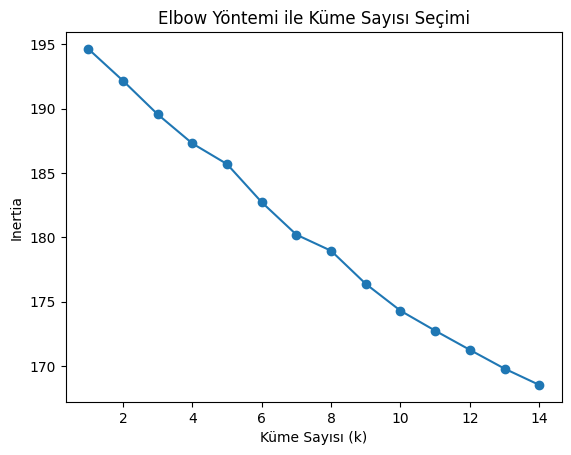

In [27]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Yöntemi ile Küme Sayısı Seçimi")
plt.show()

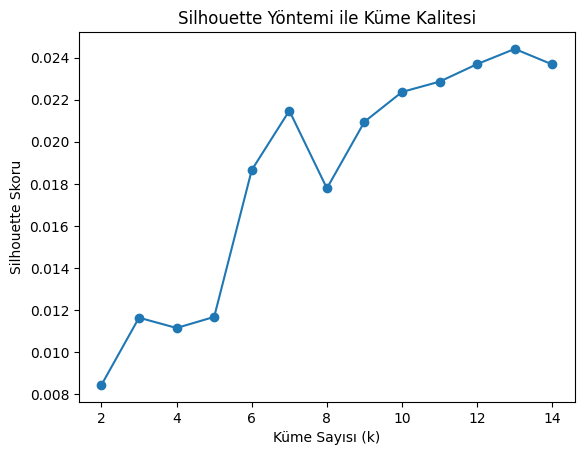

In [28]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")
plt.title("Silhouette Yöntemi ile Küme Kalitesi")
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["metin"])

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

__burada nasıl kümeler oluştuğunu görmek amacıyla bakıldı ve detaylı bakılarak hangi konularda öneri/şikayet yaşadıkları belirledikleri belirlendi__

In [31]:
for i in range(6):
    print(f"\nKÜME {i}")
    print(df[df["cluster"] == i]["onerilen_konular"].head(10).to_string(index=False))


KÜME 0
[şifre unut, kadar şifre, müşteri hizmet, gerçe...
[şifre yenile, şifre, kod rağmen, değil müşteri...
[şifre unut, unut şifre, şifre yenile, şifre, u...
[şifre koy, uğraş şifre, koy şifre, şifre, türl...
[tekrar defalarca, arkadaş şifre, şifre yenile,...
[şifre yenile, çalış şifre, iste şifre, şifre, ...
[şifre yenile, giriş şifre, şifre, güvenlik sor...
[şifre unut, şifre iste, şifre, boyunca şifre, ...
[şifre yenile, şifre, sürekli hata, hata, sürekli]
[şifre kabul, şifre yen, hafta şifre, şifre, sa...

KÜME 1
[kart işlem, aktar kart, kart bilgi, fatura yan...
[yıldız kart, kimlik tanı, aktarım kimlik, kart...
[kullandirtmayin kart, aktif kart, fakat kart, ...
[kart iyi, kart başka, tavsiye kart, başka kart...
[banka kart, kart yüklem, kart kalite, kaybet m...
[hata kart, yükle kart, kimlik doğrula, gerekiy...
[kredi kart, kart yükle, bugün kart, üstelik kr...
[kart para, sanal kart, müşteri hizmet, ara müş...
[kullan kart, inaktif kart, cevapla kart, kart ...
[kart kır, kötü

__burada kümelerdeki en önemli kelimeleri görerek hangi alanlarda şikayet/öneri belirlendi__

In [32]:
from collections import Counter
import ast

for i in range(6):
    print(f"\nKÜME {i}")
    kelimeler = []
    
    for val in df[df["cluster"] == i]["onerilen_konular"]:
        if isinstance(val, str):
            try:
                val = ast.literal_eval(val)
            except:
                continue
        if isinstance(val, list):
            kelimeler.extend(val)
    
    en_sik = Counter(kelimeler).most_common(6)
    print("En sık geçenler:", [x[0] for x in en_sik])


KÜME 0
En sık geçenler: ['şifre', 'şifre yenile', 'şifre unut', 'unut şifre', 'şifre gir', 'yeni şifre']

KÜME 1
En sık geçenler: ['sanal kart', 'kart kullan', 'banka kart', 'kredi kart', 'kart para', 'kart yüklem']

KÜME 2
En sık geçenler: ['gerek', 'yok', 'gerek yok', 'telefon', 'müşteri hizmet', 'keşke']

KÜME 3
En sık geçenler: ['turkcell', 'turkcell böyle', 'kullan turkcell', 'yok turkcell', 'müşteri', 'turkcell müşteri']

KÜME 4
En sık geçenler: ['fatura öde', 'banka', 'para gönder', 'banka hesap', 'fatura yansı', 'öde']

KÜME 5
En sık geçenler: ['iyi', 'iyi değil', 'değil', 'pek', 'iyi kötü', 'kötü']


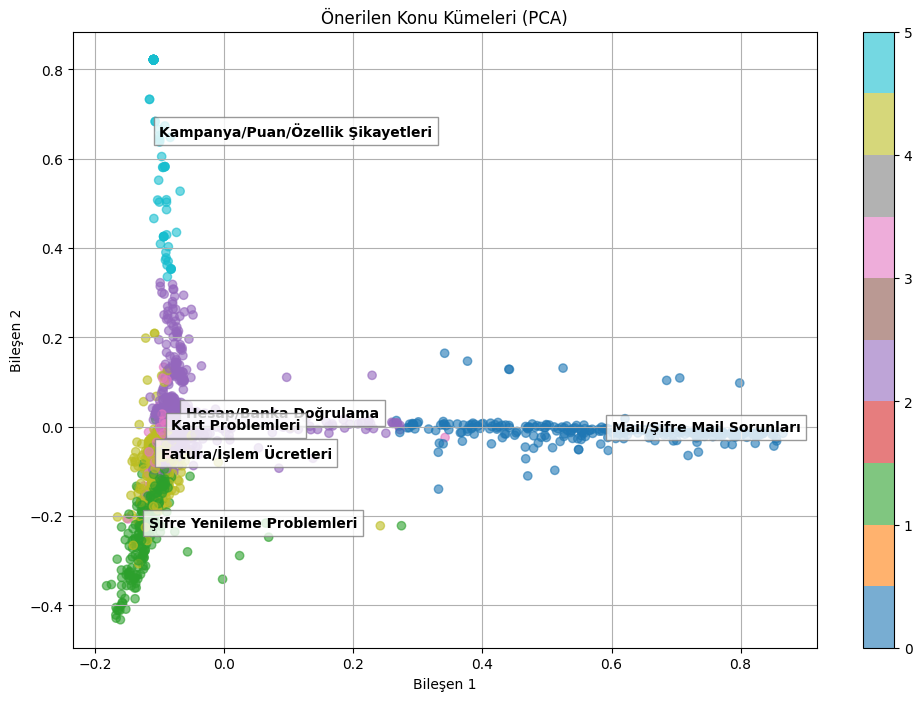

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cluster_labels = {
    0: "Mail/Şifre Mail Sorunları",
    1: "Şifre Yenileme Problemleri",
    2: "Hesap/Banka Doğrulama",
    3: "Kart Problemleri",
    4: "Fatura/İşlem Ücretleri",
    5: "Kampanya/Puan/Özellik Şikayetleri"
}

df["cluster_label"] = df["cluster"].map(cluster_labels)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", alpha=0.6)


for cluster_id in sorted(df["cluster"].unique()):
    indices = df["cluster"] == cluster_id
    x_mean = X_2d[indices, 0].mean()
    y_mean = X_2d[indices, 1].mean()
    plt.text(x_mean, y_mean, cluster_labels[cluster_id], fontsize=10, weight='bold', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.title("Önerilen Konu Kümeleri (PCA)")
plt.xlabel("Bileşen 1")
plt.ylabel("Bileşen 2")
plt.colorbar(scatter, ticks=range(len(cluster_labels)))
plt.grid(True)
plt.show()

__negatif yorumlar arasında kümelerde ne en çok geçen kelimelerin hangi kümede ne kadar çektiğine ulaştık.__

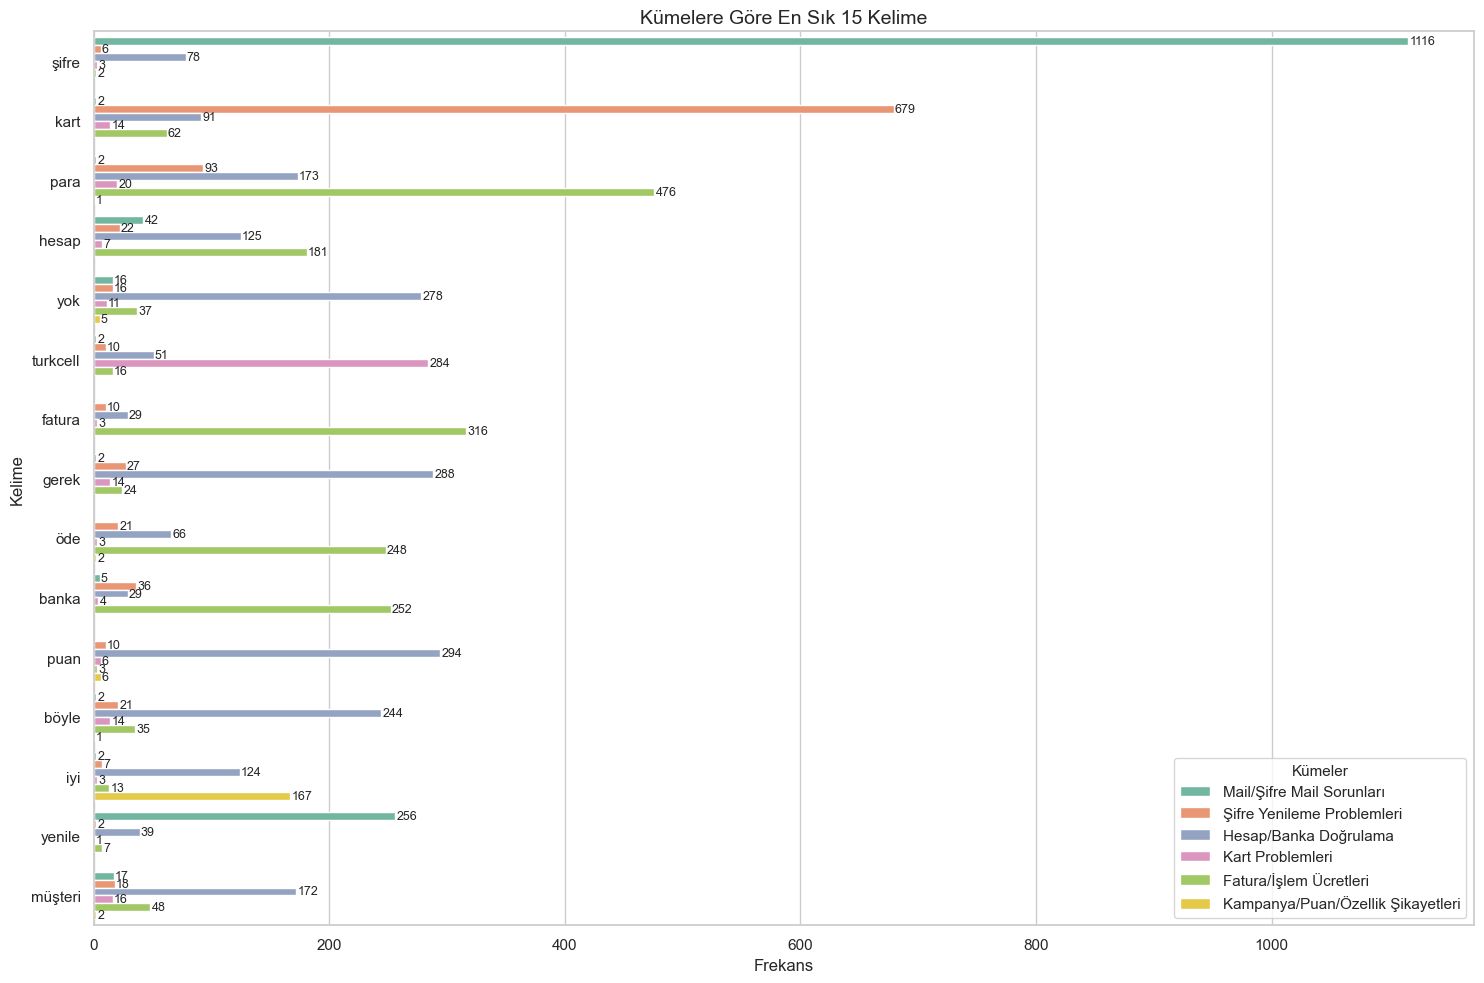

In [34]:
import seaborn as sns

rows = []
for i, row in df.iterrows():
    for kelime in row["metin"].split():
        rows.append({"cluster": row["cluster"], "kelime": kelime})

kelime_df = pd.DataFrame(rows)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

top_kelimeler = kelime_df["kelime"].value_counts().head(15).index

ax = sns.countplot(
    data=kelime_df[kelime_df["kelime"].isin(top_kelimeler)],
    y="kelime",
    hue="cluster",
    order=top_kelimeler,
    palette="Set2"
)
cluster_labels = {
    0: "Mail/Şifre Mail Sorunları",
    1: "Şifre Yenileme Problemleri",
    2: "Hesap/Banka Doğrulama",
    3: "Kart Problemleri",
    4: "Fatura/İşlem Ücretleri",
    5: "Kampanya/Puan/Özellik Şikayetleri"
}

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        plt.text(width + 1,  
                 p.get_y() + p.get_height() / 2, 
                 int(width), ha="left", va="center", fontsize=9)

plt.title("Kümelere Göre En Sık 15 Kelime", fontsize=14)
plt.xlabel("Frekans", fontsize=12)
plt.ylabel("Kelime", fontsize=12)
plt.legend(title="Cluster", title_fontsize=11)
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
new_labels = [cluster_labels[int(label)] for label in labels]
ax.legend(handles, new_labels, title="Kümeler", title_fontsize=11)
plt.show()


__bu negatif verilerde en çok geçen kelimeler__

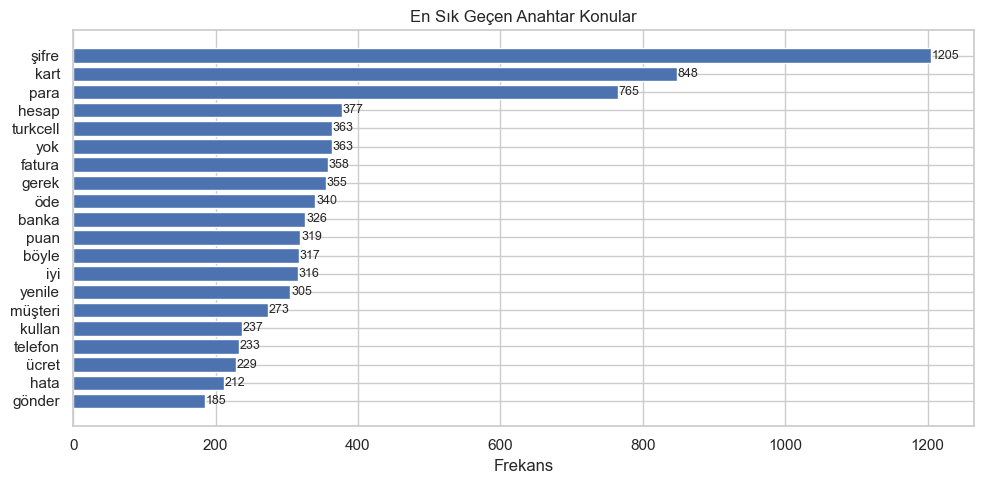

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

all_keywords = df["metin"].str.split().sum() 
common = Counter(all_keywords).most_common(20)

labels, counts = zip(*common)
plt.figure(figsize=(10, 5))
bars = plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.title("En Sık Geçen Anahtar Konular")
plt.xlabel("Frekans")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             str(int(width)), va='center', fontsize=9)

plt.tight_layout()
plt.show()


__POZITIF VERILER ICIN__

__negatifler için yaptığımız durumu pozitif veriler için uyguluyoruz__

In [36]:
import ast
df_cleaned = pd.read_csv("../data/sentiment_results.csv")
df_cleaned["lemmas"] = df_cleaned["lemmas"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

positive_df = df_cleaned[df_cleaned["normalized_pred_label"] == "positive"].copy()
df_cleaned = positive_df.dropna(subset=["lemmas"])

In [37]:
suggest_df = df_cleaned[df_cleaned["normalized_pred_label"] == "positive"].copy()

__Model olarak kullanılan bu model cümlelerin anlamını vektöre çevirerek benzerlik üzerinden anahtar kelime seçiyor.__


In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT(model="paraphrase-multilingual-MiniLM-L12-v2")

def extract_keywords(tokens):
    if not isinstance(tokens, list) or len(tokens) == 0:
        return []
    text = " ".join(tokens)
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=5
    )
    return [kw[0] for kw in keywords]

suggest_df.loc[:, "positif_oneriler"] = suggest_df["lemmas"].apply(extract_keywords)

In [ ]:
output_df = suggest_df[["lemmas", "positif_oneriler"]].copy()
output_df.to_csv("lemmas_suggest_positive.csv", index=False, encoding="utf-8-sig")

In [ ]:
import pandas as pd
import ast

df = pd.read_csv("lemmas_suggest_positive.csv")

df["positif_oneriler"] = df["positif_oneriler"].apply(ast.literal_eval)

df["metin"] = df["positif_oneriler"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else ""
)

df = df[df["metin"].str.strip().astype(bool)].copy()

__burada cluster olarak 3 seçtik çünkü elbow ve Silhouette ile dirsek noktaları ve çeşitli denemeler sonucu 3 kararı alındı__

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Yöntemi ile Küme Sayısı Seçimi")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")
plt.title("Silhouette Yöntemi ile Küme Kalitesi")
plt.show()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["metin"])

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [ ]:
for i in range(3):
    print(f"\nKÜME {i}")
    print(df[df["cluster"] == i]["positif_oneriler"].head(5).to_string(index=False))

__Burada kelimelerin anlamı açısından kümelendirme sonucu oluşan 3 kümeye ayırdık bunun sonucunda kendi dağılımları görselleştirildi__

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10")
plt.title("KMeans ile Önerilen Konu Kümeleme (PCA)")
plt.xlabel("Bileşen 1")
plt.ylabel("Bileşen 2")
plt.colorbar(scatter, ticks=range(3))
plt.grid(True)
plt.show()

__en çok geçen pozitif kelime belirlenmiş oldu__

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

all_keywords = df["metin"].str.split().sum() 
common = Counter(all_keywords).most_common(20)

labels, counts = zip(*common)
plt.figure(figsize=(10, 5))
plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.title("En Sık Geçen Anahtar Konular")
plt.xlabel("Frekans")
plt.show()

__en çok kelimelerin hangi kümelerde ne kadar geçtiğine dair görselleştirme__

In [ ]:
import seaborn as sns
import pandas as pd

rows = []
for i, row in df.iterrows():
    for kelime in row["metin"].split():
        rows.append({"cluster": row["cluster"], "kelime": kelime})

kelime_df = pd.DataFrame(rows)
plt.figure(figsize=(12, 6))
sns.countplot(data=kelime_df, y="kelime", order=kelime_df["kelime"].value_counts().head(15).index, hue="cluster")
plt.title("Kümelere Göre En Sık Kelimeler")
plt.show()